In [11]:
#import libraries

import os
import torch
import torch.nn as nn
import numpy as np
#import libraries

import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import os
directory_path = "/content/drive/MyDrive/Cotton Disease"
print(os.listdir(directory_path))


['test', 'train', 'val']


In [13]:
print(os.listdir(directory_path))
classes = os.listdir(directory_path + "/train")
print(classes)

['test', 'train', 'val']
['fresh cotton leaf', 'fresh cotton plant', 'diseased cotton plant', 'diseased cotton leaf']


In [14]:
diseased_cotton_leaf = os.listdir(directory_path + "/train/diseased cotton leaf")
print(diseased_cotton_leaf[:10])

['dis_leaf (111)_iaip.jpg', 'dis_leaf (120)_iaip.jpg', 'dis_leaf (110)_iaip.jpg', 'dis_leaf (121)_iaip.jpg', 'dis_leaf (126)_iaip.jpg', 'dis_leaf (139)_iaip.jpg', 'dis_leaf (102)_iaip.jpg', 'dis_leaf (125)_iaip.jpg', 'dis_leaf (108)_iaip.jpg', 'dis_leaf (130)_iaip.jpg']


In [15]:
for i in classes:
  result = os.listdir(directory_path + "/train/" + i)
  print(f"Number of Images in {i} = {len(result)}")

Number of Images in fresh cotton leaf = 427
Number of Images in fresh cotton plant = 421
Number of Images in diseased cotton plant = 815
Number of Images in diseased cotton leaf = 288


In [16]:
image_size = 32
batch_size = 200
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [17]:
train_ds = ImageFolder(directory_path + "/train", transform=T.Compose ([
    T.Resize((image_size, image_size)),
    T.CenterCrop((image_size, image_size)),
    T.ToTensor(), T.Normalize(*stats)
]))

val_ds = ImageFolder(directory_path + "/val", transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop((image_size, image_size)),
    T.ToTensor(), T.Normalize(*stats)
]))

In [18]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [19]:
def denorm(img_tensors):
  return img_tensors * stats[1][10] + stats[0][0]

In [20]:
from torchvision.utils import make_grid

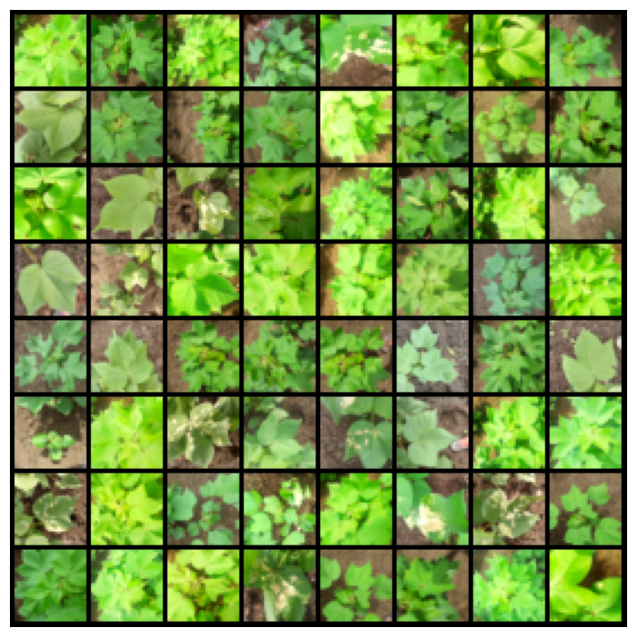

In [21]:
# Define the normalization parameters
means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

# Function to denormalize images
def denormalize(images, means, stds):
    means = torch.tensor(means).view(1, 3, 1, 1)
    stds = torch.tensor(stds).view(1, 3, 1, 1)
    return images * stds + means

# Function to show images
def show_images(images, means, stds, nmax=64):
    images = denormalize(images, means, stds)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:nmax], nrow=8).permute(1, 2, 0))

# Function to show a batch
def show_batchs(dl, means, stds, nmax=64):
    for images, _ in dl:
        show_images(images, means, stds, nmax)
        break

# Call the function
show_batchs(train_dl, means, stds, nmax=64)


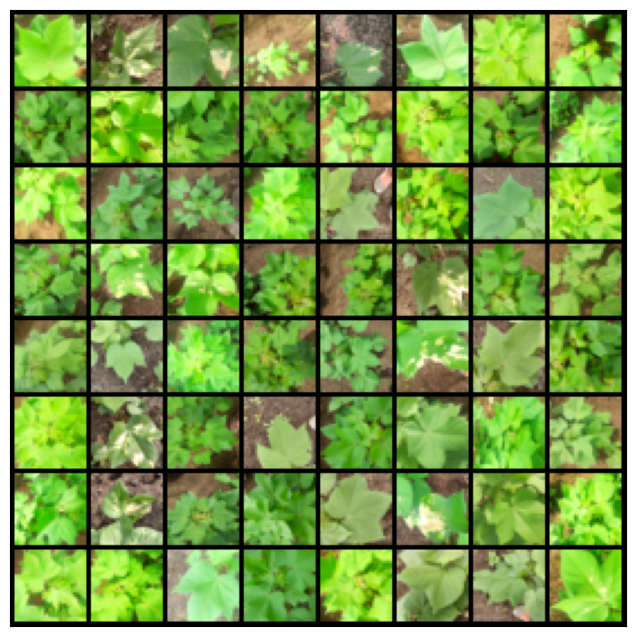

In [22]:
show_batchs(train_dl, means, stds)
torch.cuda.empty_cache()

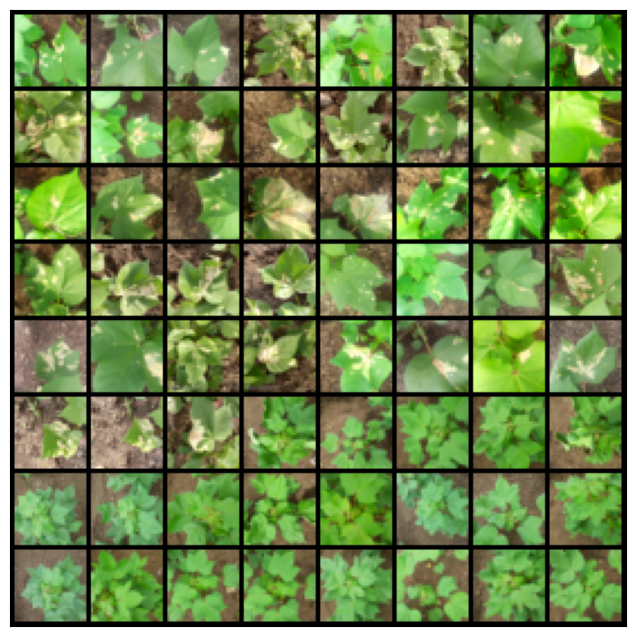

In [23]:
show_batchs(val_dl, means, stds)

In [24]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = self.accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(),'val_acc':epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}],train_loss: {:.4f},val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc']
    ))
def accuracy(self, outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [25]:
class CnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),

        nn.Flatten(),
        nn.Linear(256*4*4, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512,4)
    )

  def forward(self, xb):
    return self.network(xb)

  def accuracy(self, outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))



In [26]:
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=512, bias=True)
    (17): ReLU()
    (18): Linear(in_features=512

In [27]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for images, labels in train_dl:
  print('images.shape:', images.shape)


  images = images.to(device)

  out = model(images)
  print('out.shape:', out.shape)
  print('out[0]:', out[0])
  break


images.shape: torch.Size([200, 3, 32, 32])
out.shape: torch.Size([200, 4])
out[0]: tensor([ 0.0419, -0.0421, -0.0315, -0.0203], grad_fn=<SelectBackward0>)


In [28]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [29]:
device = get_default_device()
device

device(type='cpu')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model,device);

In [31]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(),lr)
  for epoch in range(epochs):
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history



In [32]:
model = to_device(CnnModel(), device)


In [33]:
evaluate(model, val_dl)

{'val_loss': 1.3903604745864868, 'val_acc': 0.16996046900749207}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [38]:
%%time
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0],train_loss: 0.7017,val_loss: 0.5209, val_acc: 0.8498
Epoch [1],train_loss: 0.3877,val_loss: 0.4412, val_acc: 0.8379
Epoch [2],train_loss: 0.2776,val_loss: 0.2858, val_acc: 0.8933
Epoch [3],train_loss: 0.2045,val_loss: 0.2652, val_acc: 0.9091
Epoch [4],train_loss: 0.1536,val_loss: 0.3391, val_acc: 0.9091
Epoch [5],train_loss: 0.1384,val_loss: 0.2437, val_acc: 0.9012
Epoch [6],train_loss: 0.1204,val_loss: 0.2134, val_acc: 0.9170
Epoch [7],train_loss: 0.1102,val_loss: 0.2615, val_acc: 0.9130
Epoch [8],train_loss: 0.0823,val_loss: 0.3252, val_acc: 0.9091
Epoch [9],train_loss: 0.0561,val_loss: 0.2519, val_acc: 0.9051
CPU times: user 5min 57s, sys: 20.9 s, total: 6min 18s
Wall time: 8min 35s


In [39]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs No. of epochs')

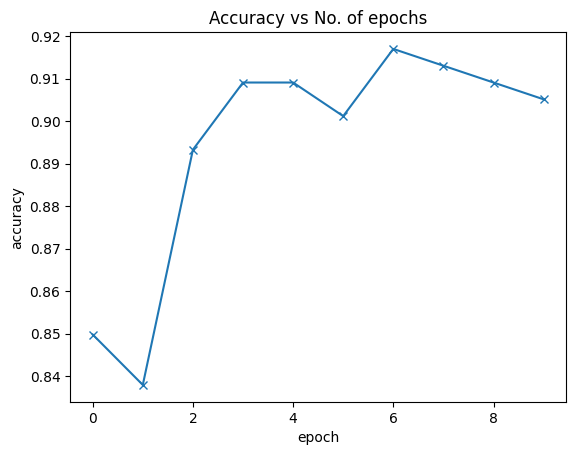

In [40]:
plot_accuracies(history)

In [41]:
def plot_losses(history):
  train_losses = [x.get('train_loss') for x in history]
  val_losses = [x ['val_loss'] for x in history]
  plt.plot(train_losses, '-bx')
  plt.plot(val_losses, '-rx')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['Training', 'Validation'])
  plt.title('Loss vs No. of epochs')

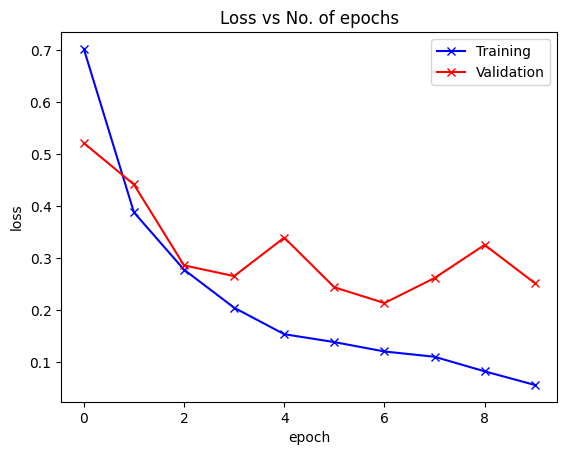

In [42]:
plot_losses(history)

In [43]:
test_dataset =  ImageFolder(directory_path + "/test", transform=T.Compose([
    T.Resize((image_size, image_size)),
    T.CenterCrop((image_size, image_size)),
    T.ToTensor(), T.Normalize(*stats)
]))

In [44]:
def predict_image(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return train_ds.classes[preds[0].item()]

In [45]:
dataset = ImageFolder(directory_path + "/train", transform=ToTensor())

In [ ]:
torch.save(model.state_dict(), 'cotton_disease_model.pth')

In [49]:
def denorm(img_tensors):
    # Unnormalize the image tensor using mean and std for each channel
    mean = torch.tensor(stats[0])  # mean = [mean_r, mean_g, mean_b]
    std = torch.tensor(stats[1])   # std = [std_r, std_g, std_b]
    return img_tensors * std + mean


label: diseased cotton leaf ,Predicted: diseased cotton leaf


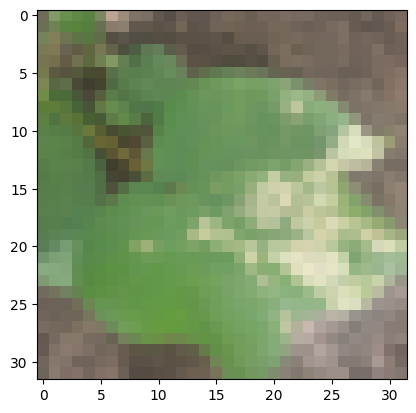

In [51]:
test_dataset1 =  ImageFolder(directory_path + "/test", transform=ToTensor())
img, label = test_dataset[0]
plt.imshow(denorm(img.permute(1,2,0)))
print('label:', dataset.classes[label], ',Predicted:', predict_image(img, model))

In [52]:
torch.cuda.empty_cache()